# 3D_model

I solve the time-independent diffusion equation for a cubic domain with an elliptical absorber (modelling a stoma) on the bottom face. The side and top faces have a Dirichlet boundary condition set. The flux to the absorber is compared to an analytic model.

In [1]:
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
from scipy.optimize import curve_fit

plt.rcParams['lines.linewidth'] = 3

# Set the simulation parameters

In [2]:
xmax, ymax, zmax = 200, 200, 200 #dimensions of the domain in um
x0, y0 = 100, 100 #position of the stoma
radx, rady = 15, 15 #radii of the stoma
nx,ny,nz = 101, 101, 101 #number of grid segments
tol= 0.001 #tolerance used in setting up the boundary conditions

mesh = fe.BoxMesh(fe.Point(0,0,0),fe.Point(xmax,ymax,zmax),nx,ny,nx)
V = fe.FunctionSpace(mesh, 'CG', 1)

x_vals = np.linspace(0,xmax,nx) 
y_vals = np.linspace(0,ymax,ny) 
z_vals = np.linspace(0,zmax,nz) 

# Set the boundary conditions

In [3]:
class Stoma(fe.SubDomain):     
    def inside(self, x, on_boundary):
        if fe.between(x[2], (-tol, tol)):
            if (x[0]-x0)**2/radx**2+(x[1]-y0)**2/rady**2<1:
                return True
    
class Top(fe.SubDomain):
    def inside(self, x, on_boundary):
        return fe.between(x[2], (zmax-tol, zmax+tol))
    
class Back(fe.SubDomain):
    def inside(self, x, on_boundary):
        return fe.between(x[1], (ymax-tol, ymax+tol))

class Front(fe.SubDomain):
    def inside(self, x, on_boundary):
        return fe.between(x[1], (-tol, tol))
    
class Left(fe.SubDomain):
    def inside(self, x, on_boundary):
        return fe.between(x[0], (xmax-tol, xmax+tol))

class Right(fe.SubDomain):
    def inside(self, x, on_boundary):
        return fe.between(x[0], (-tol, tol))
    
stoma = Stoma()
top = Top()
back = Back()
front = Front()
left = Left()
right = Right()

boundaries = {stoma:0, top:1, back:1, front:1, left:1, right:1}

bcs = []
for boundary in boundaries:
    bcs.append(fe.DirichletBC(V,fe.Constant(boundaries[boundary]),boundary))

# Solve the PDE

In [10]:
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
L = fe.Constant('0') * v * fe.dx
u = fe.Function(V)
%time fe.solve(a == L, u,bcs, solver_parameters={'linear_solver':'bicgstab','preconditioner':'ilu'})

CPU times: user 8.95 s, sys: 212 ms, total: 9.16 s
Wall time: 8.9 s


# Take some slices through the numerical solution

In [5]:
uxz100 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        uxz100[i,j] = u(i*xmax/(nx-1),100,j*zmax/(nz-1))
        
uxy0 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        uxy0[i,j] = u(i*xmax/(nx-1),j*zmax/(nz-1),0)

uxy1 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        uxy1[i,j] = u(i*xmax/(nx-1),j*zmax/(nz-1),1)

# Plot the cross-sections

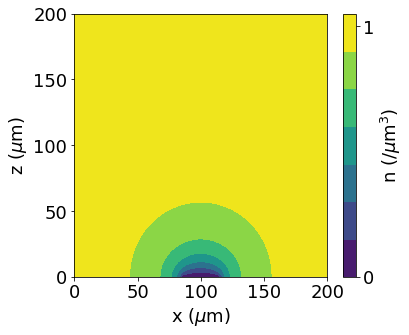

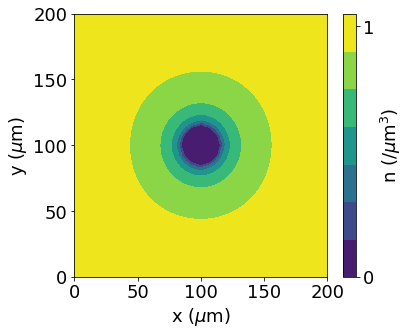

In [6]:
fig,ax = plt.subplots(1,1,figsize=[6,5])

myplot = ax.contourf(x_vals, z_vals,uxz100.T,vmin=0,vmax=1)
my_cbar = fig.colorbar(myplot)
my_cbar.set_label('n (/$\mu$m$^3$)')
my_cbar.set_ticks([0,1])

ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('z ($\mu$m)')
fig.tight_layout()
fig.savefig('xz.png',dpi=150)

fig,ax = plt.subplots(1,1,figsize=[6,5])

myplot = ax.contourf(x_vals, y_vals,uxy0.T+1e-10,vmin=0,vmax=1)
my_cbar = fig.colorbar(myplot)
my_cbar.set_label('n (/$\mu$m$^3$)')
my_cbar.set_ticks([0,1])
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

fig.tight_layout()
fig.savefig('xy.png',dpi=150)

# Fit and plot individual traces

Lx = 22.6
Lx = 170.6


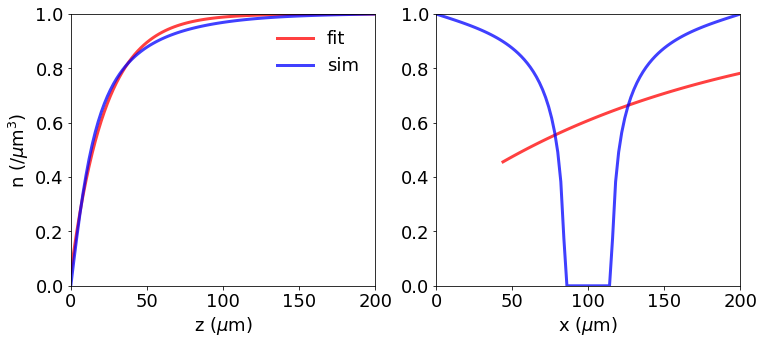

In [7]:
fig,ax = plt.subplots(1,2,figsize=[12,5])

#define the slices
z_trace = uxz100[nx//2,:]
x_trace = uxy0[nx//2,:]

def exp_rise(x,L,x0):
    return 1 - np.exp(-(x-x0)/L)

#curve fit the z trace
popt,pcov = curve_fit(exp_rise,z_vals,z_trace,p0=[20,110])
print('Lx = {:0.1f}'.format(popt[0]))

#plot the results
ax[0].plot(z_vals,exp_rise(z_vals,*popt),color='r',alpha = 0.75,label='fit')
ax[0].plot(z_vals,z_trace,color='b',label='sim',alpha = 0.75)

#curve fit the x trace
popt,pcov = curve_fit(exp_rise,x_vals[22:],x_trace[22:],p0=[20,110])
print('Lx = {:0.1f}'.format(popt[0]))

#plot the results
ax[1].plot(x_vals[22:],exp_rise(x_vals[22:],*popt),color='r',alpha = 0.75)
ax[1].plot(x_vals,x_trace,color='b',alpha = 0.75)

#annotate the plots
ax[0].set_xlabel('z ($\mu$m)')
ax[0].set_ylabel('n (/$\mu$m$^3$)')
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,zmax])

ax[1].set_xlabel('x ($\mu$m)')
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,xmax])
ax[0].legend(frameon=False)

fig.savefig('line.png',dpi=150)

# Determining and plotting the flux

The current as determined by the flux is 63.58 /s
The theoretical flux is 60 /s


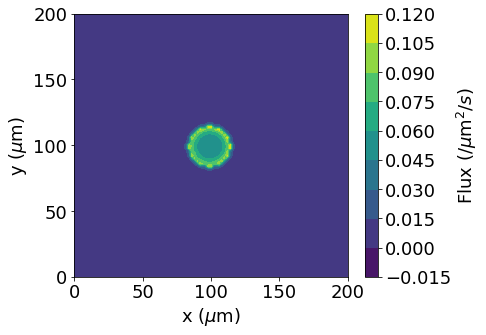

In [8]:
flux = uxy1-uxy0
print('The current as determined by the flux is {:0.2f} /s'.format(np.sum(flux)*(xmax/(nx-1))**2))
print('The theoretical flux is {} /s'.format(4*1*radx))

fig,ax = plt.subplots(1,1,figsize=[7,5])
myplot = ax.contourf(x_vals, y_vals,flux.T)
my_cbar = fig.colorbar(myplot)
my_cbar.set_label('Flux (/$\mu$m$^2/s$)')


ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
fig.tight_layout()


fig.savefig('flux.png',dpi=150)

## Generate featured image

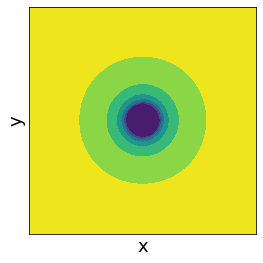

In [9]:
fig,ax = plt.subplots(1,1,figsize=[4,4])

myplot = ax.contourf(x_vals, y_vals,uxy0.T+1e-10,vmin=0,vmax=1)
#my_cbar = fig.colorbar(myplot)
#my_cbar.set_label('n (/$\mu$m$^3$)')
#my_cbar.set_ticks([0,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig('xy_feat.png',dpi=150)